# How-To Guide into Feature Selection  

## Introduction

This is the third post in my series on transforming data into alpha.  If you haven't yet see the [framework overview]() or [feature engineering guide](), please take a minute to read that first...    

This post is going to delve into the mechanics of _feature selection_, in other words choosing between the many variations of features you've created in the feature engineering stage.   By design, many of the features you've created will be very similar to each other (aka "collinear") because you've derived them from the same underlying dataset.  

## Motivation

The previous step of the process, feature engineering, is intended to be a creative, loose process akin to a brainstorming session.  The result should be tens (or hundreds) of variations of features to evaluate.  However, most models will _generalize_ better (i.e., work well on data they haven't seen) with fewer features.  They will also be much more interpretable.  

Therefore, we need a systematic approach to deciding which of the many posible features to use.  That's where the _feature selection_ process comes in.   


## Philosophy

In feature selection, we strive to meet two goals:
1. __Strength__:  Choose the features with the strongest, most persistent relationships to the target outcome variable.  The reasons for this are obvious.
2. __Orthogonality__:  Minimize the amount of overlap or collinearity in your selected features.  The importance of orthogonality (non-overlap) of features is much greater than you might guess.  

I am biased towards making feature selection a relatively mechanical process.  The "art" should mainly be encapsulated within the prior step (feature engineering) and the subsequent step (modeling).  Feature selection should, in my view, follow a heuristic and can be encoded into an algorithm if desired.  For purposes of this tutorial, I'll keep things relatively manual.   

## Getting Started
Let's dive in.  I will begin by loading the feature set created in the prior step.  I'm also going to create the _outcomes_ `DataFrame` as done in the Framework Overview post.  Please refer to those if you haven't already.  



In [3]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline


def get_symbols(symbols,data_source, begin_date=None,end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)[['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date','symbol'])
        out = pd.concat([out,df],axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)

prices.sort_index().tail()

open      high      low    close      volume
date       symbol                                                 
2018-03-26 MSFT      90.61    94.000    90.40    93.78  55031149.0
2018-03-27 AAPL     173.68   175.150   166.92   168.34  38962839.0
           AMZN    1572.40  1575.960  1482.32  1497.05   6793279.0
           CSCO      44.49    44.520    42.24    42.68  30088447.0
           MSFT      94.94    95.139    88.51    89.47  53704562.0

In [4]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1) # next day's returns
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5) # next week's returns
outcomes['close_10'] = prices.groupby(level='symbol').close.pct_change(-10) # next two weeks' returns
outcomes['close_20'] = prices.groupby(level='symbol').close.pct_change(-20) # next month's (approx) returns

outcomes.tail()

close_1  close_5  close_10  close_20
date       symbol                                       
2018-03-26 MSFT    0.048173      NaN       NaN       NaN
2018-03-27 AAPL         NaN      NaN       NaN       NaN
           AMZN         NaN      NaN       NaN       NaN
           CSCO         NaN      NaN       NaN       NaN
           MSFT         NaN      NaN       NaN       NaN

For purposes of illustration, we'll engineer some features to contain some signal buried within the noise.  Clearly, this is not something we'd do in real usage but will help to demonstrate the concept more clearly.  

Assume we have a target variable called `outcome` which can be (partially) predicted with three factors, `factor_1`, `factor_2` and `factor_3`.  There's also an unpredictble noise component.  We will "cheat" and create the overall target variable from these factors.  All data will follow the same index as the market data we pulled from quandl.  

In [5]:
num_obs = prices.close.count()
factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
outcome = 1.*factor_1 + 2.*factor_2 + 3.*factor_3 + 5.*np.random.randn(num_obs)
outcome.name = 'outcome'
outcome.tail()


date        symbol
2018-03-26  MSFT     -10.095753
2018-03-27  AAPL       0.771417
            AMZN      -0.687236
            CSCO      -0.412196
            MSFT       0.713697
Name: outcome, dtype: float64

Now, we will engineer several variations on features which each contain some information about the three factors, plus a few which contain some interaction effects, and some which do not contain any useful data.  

Note that we are, again, "cheating" here for illustration purposes. 

In [6]:
features = pd.DataFrame(index=outcome.index)
features['f11'] = 0.2*factor_1 + 0.8*np.random.randn(num_obs)
features['f12'] = 0.4*factor_1 + 0.6*np.random.randn(num_obs)
features['f13'] = 0.6*factor_1 + 0.4*np.random.randn(num_obs)

features['f21'] = 0.2*factor_2 + 0.8*np.random.randn(num_obs)
features['f22'] = 0.4*factor_2 + 0.8*np.random.randn(num_obs)
features['f23'] = 0.6*factor_2 + 0.4*np.random.randn(num_obs)

features['f31'] = 0.2*factor_3 + 0.8*np.random.randn(num_obs)
features['f32'] = 0.4*factor_3 + 0.6*np.random.randn(num_obs)
features['f33'] = 0.6*factor_3 + 0.4*np.random.randn(num_obs)

features['f41'] = 0.2*factor_1+0.2*factor_2 + 0.6*np.random.randn(num_obs)
features['f42'] = 0.2*factor_2+0.2*factor_3 + 0.6*np.random.randn(num_obs)
features['f43'] = 0.2*factor_3+0.2*factor_1 + 0.6*np.random.randn(num_obs)

features['f51'] = np.random.randn(num_obs)
features['f52'] = np.random.randn(num_obs)
features['f53'] = np.random.randn(num_obs)

features.tail()


f11       f12       f13       f21       f22       f23  \
date       symbol                                                               
2018-03-26 MSFT    0.270354  0.640479  0.312507  1.076263 -1.140330  0.125225   
2018-03-27 AAPL    1.356990 -0.063781  0.364178  1.060267  0.785495  0.685358   
           AMZN   -1.509850  0.337900 -0.907325  1.483814  1.534616  0.895938   
           CSCO    0.219328  0.170100  0.238389 -0.051780 -0.777215  0.056822   
           MSFT    0.843976 -0.175080 -0.382519  0.231769 -0.641720  0.151481   

                        f31       f32       f33       f41       f42       f43  \
date       symbol                                                               
2018-03-26 MSFT   -0.480357 -0.484713 -0.888125  0.483008 -0.084135 -0.797154   
2018-03-27 AAPL    0.006471 -0.198058 -1.225844  1.271360 -1.088801  0.518321   
           AMZN    0.660212 -0.405371  1.435133 -0.424031  1.241517  0.320264   
           CSCO    0.277272 -0.633173  0.579801  1.066081  0.753961  0.553908   
           MSFT   -0.776813  0.068307  0.462349 -0.193042 -1.152931 -0.637286   

                        f51       f52       f53  
date       symbol                                
2018-03-26 MSFT   -0.088401  0.904657 -0.076851  
2018-03-27 AAPL    0.775822  0.509112 -0.854521  
           AMZN   -0.797960 -0.310141  0.066523  
           CSCO   -1.059631 -2.462920 -0.041167  
           MSFT   -2.544443  0.301099 -1.518330

Next, we'll import the required packages and modules for the feature selection:

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


Before evaluating the features for predictive strength and orthogonality, we'll do a quick data preparation stage. It is sometimes vital to "standardize" or "normalize" data so that we get fair comparisons between features of differing scale.  Strictly speaking, since all of the doctored outcome and feature data is already drawn from normal distribution (using the numpy function `random.rnorm()`) we don't really need this step, but good practice to include.  

Here, I'll use the scikit-learn `StandardizeScaler()` method and some pandas magic to transform the data.  

In [8]:
#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print (features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
outcome_scaled.tail()


(7639, 15)


outcome
date       symbol          
2018-03-26 MSFT   -1.602176
2018-03-27 AAPL    0.129031
           AMZN   -0.103342
           CSCO   -0.059526
           MSFT    0.119836

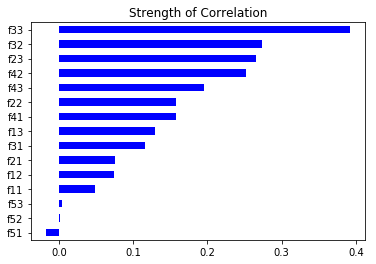

In [9]:
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

Pretend for a minute that we don't know which features are going to be stronger and weaker, and which are going to tend to cluster together.  We've got an idea that there are some quite strong features, some weaker, and some useless.  
Next, we'll take advantage of a very handy seaborn chart type called a "clustermap" which plots a heatmap representation of a correlation matrix and runs a clustering algorithm to group together the most closely related features.  

Of course, the diagonal of dark green represents each feature being perfectly correlated with itself.

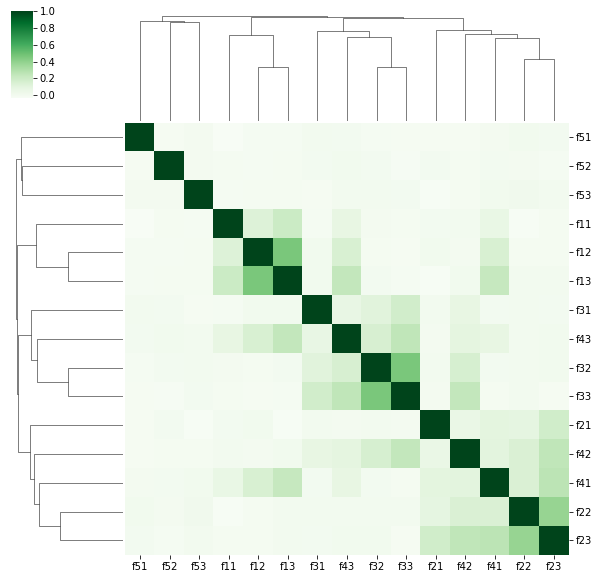

In [10]:

corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,\
                   col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns



The algorithm has done a good job of finding the groupings of features.  The cluster in the upper left captures `factor_1` (including some of the interaction effects).  `factor_3` is fairly well isolated in the lower right corner, and in the middle we can see `factor_2` as well as some of the noise features. 

Let's next focus in only on those features with correlations of greater than 0.1 to exclude the noise and weak features.

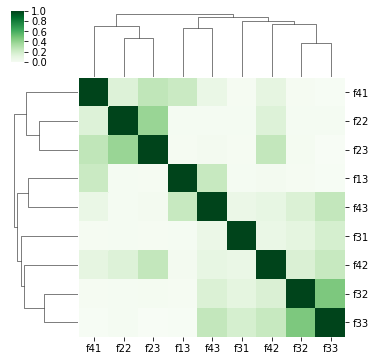

Correlation Strength:
f33    0.392217
f32    0.273283
f23    0.265816
f42    0.252034
f43    0.196029
f22    0.158054
f41    0.157401
f13    0.128733
f31    0.116092
dtype: float64


In [11]:
correlated_features = corr[corr>0.1].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,\
                   col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

Ah, now the clusters look a bit sharper.  We'll follow a simple heuristic to manually select the features.  Those wishing to take this to the next level can decide how to encapsulate into an algorithm.  

1. Take the most strongly correlated feature (f33) and add it to our list of selected features.
2. Take the second correlated feature (f23) and check to see if it's closely correlated (neighboring in the clustermap) to any features already chosen.  If no, add to the list.  If yes, discard.
3. Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.  

Following that heuristic, I get:

In [12]:
selected_features = ['f33','f23','f42','f41','f31']

Note that this list of features is not simply the highest correlated features.  Let's run the clustermap one more time to see if we've missed any major clusters.  

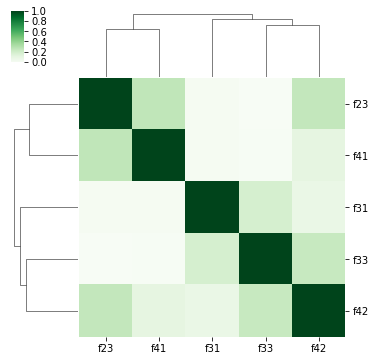

In [13]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,\
                   col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns


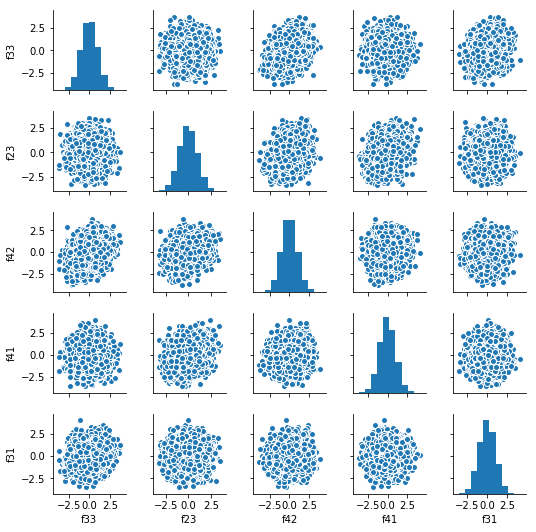

In [17]:
import seaborn as sns
sns.pairplot(df[selected_features],size=1.5)

Looks generally pretty good.  This can be a bit subjective to determine what's "too close" and what's "too weak", but that's the basic idea.  

Thus far, we've only taken a simple correlation statistic to be representative of predictive power.  In my opinion, that's a good place to start but because financial time series data suffers from [non-stationarity]() and [regime change](), we'll plot the rolling correlation of these selected features to see if any is either (1) less correlated now than in times past or (2) very "hot-and-cold".  

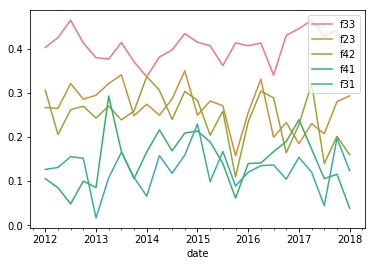

In [147]:
tmp = df[selected_features].join(outcome_scaled).reset_index().set_index('date')
tmp.dropna().resample('Q').apply(lambda x: x.corr()).iloc[:,-1].unstack().iloc[:,:-1].plot()
# shows time stability

As expected, since the data wasn't modeled with any non-stationarity, our features all appear to be robust over time.

### Z-Scores
A very popular/useful transformation for financial time series data is the [z-score](http://stattrek.com/statistics/dictionary.aspx?definition=z-score).  We can easily define a generalized lambda function for this, which we can use whenever needed.  Importantly, it allows us to mix together very different symbols (some high-beta, some low-beta) in a way that considers the statistical significance of any movement.  


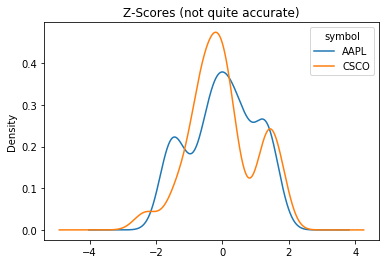

In [8]:
zscore_fxn = lambda x: (x - x.mean()) / x.std()
features['f09'] =prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

However, the above example has a subtle but important bug.  It uses the mean _of the whole time frame_ and the standard deviation _of the whole time frame_ to calculate each datapoint.  This means we are peeking ahead into the future and the feature is potentially very danger-prone (it'll work famously well in sample and fail to work out of sample...).

Fixing this is cumbersome, but necessary.  

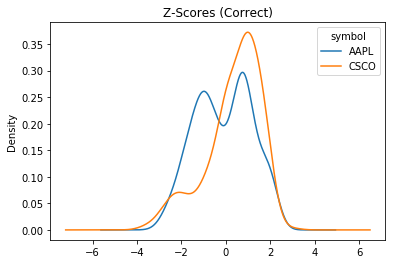

In [9]:
zscore_fun_improved = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/ x.rolling(window=200, min_periods=20).std()
features['f10'] =prices.groupby(level='symbol').close.apply(zscore_fun_improved)
features.f10.unstack().plot.kde(title='Z-Scores (Correct)')

### Percentile
Less commonly used - but equally useful - is the percentile transformation.  Getting this done properly in pandas (with groupby and rolling) is possible but tricky.  The below example returns the percentile rank (from 0.00 to 1.00) of traded volume for each value as compared to a trailing 200 day period.  

Note that we need to use _a lambda within a lambda_ to make this work properly.  We're on the bleeding edge.


In [10]:
rollrank_fxn = lambda x: x.rolling(200,min_periods=20).apply(lambda x: pd.Series(x).rank(pct=True)[0],raw=True)
features['f11'] = prices.groupby(level='symbol').volume.apply(rollrank_fxn)

Another interesting application of this same pattern is to rank each stock _cross-sectionally_ rather than _longitudinally_ as above.  In other words, where does this stock rank within all of the stocks on that day, not for all prior days of that stock.  The below example isn't very meaningful with only two stocks, but quite useful when using a realistic universe.  In this example, we're also making use of an earlier feature (relative volume) to compare which symbol is most heavily traded _for that stock's normal range_ in a given day.  Also note that we need to `dropna()` prior to ranking because `rank` doesn't handle nulls very gracefully.   

In [11]:
features['f12'] = features['f07'].dropna().groupby(level='date').rank(pct=True) 


### Technical Analysis
Those with a taste for technical analysis may find it difficult to let go of your favored TA techniques.  While this is not _my_ favored approach, you'll have no problem engineering features using these methods.  From my cursory googling, it looked as though the `ta` package would be a good place to start.  Very new and only one contributor but it looks fairly complete and well documented.  If you find that it's missing your favorite indicators, consider contributing to the package.  If you know of better such packages, please post in the comments below...  

You may consider mean-centering a technical indicator so that machine learning methods can make better use of the data (or make sure to include that in the pre-processing pipeline when you start modeling).  


In [12]:
import ta # technical analysis library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/
# money flow index (14 day)
features['f13'] = ta.momentum.money_flow_index(prices.high, prices.low, prices.close, prices.volume, n=14, fillna=False)
# mean-centered money flow index
features['f14'] = features['f13'] - features['f13'].rolling(200,min_periods=20).mean()


## Alternative Representations
A bit different than transforms are "representations", i.e., other ways to represent continuous values.  All of the transforms above returned continuous values rather than "labels", and that's often a good place to start - especally for early prototypes.

However, you may want to represent the data in different ways, especially if using classification-based approaches or worried about the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) due to large numbers of features.  

### Binning
We can easily convert a continous variable to discrete "bins" (like 1 to 10).  This loses information, of course, but sometimes loss of information is a good thing if you are removing more noise than signal.  

The below example shows volumes converted into ten equally sized buckets.  In other words, we've converted a continuous variable into a discrete one.  

NOTE: this example is not applied in a rolling fashion, so it __does suffer from some data peeking__, a cardinal sin.  At the moment, I'm failing in my efforts to implement it in a rolling way.  I'd be grateful for code snippets if anyone knows how to do this offhand.   

In [13]:
n_bins = 10
bin_fxn = lambda y: pd.qcut(y,q=n_bins,labels = range(1,n_bins+1))
features['f15'] = prices.volume.groupby(level='symbol').apply(bin_fxn)


### Sign
Very simply, you may wish to convert continuous variables into positive or negative (1 or -1) values, depending on input.  For instance, was volume increasing or decreasing today?  


In [14]:
features['f16'] = features['f05'].apply(np.sign)


### Plus-Minus
You may be interested in how many days in a row a value has increased (or decreased).  Below is a simple pattern to do just that - it calculates the number of up-days minus the number of down days.  


In [15]:
plus_minus_fxn = lambda x: x.rolling(20).sum()
features['f17'] = features['f16'].groupby(level='symbol').apply(plus_minus_fxn)

### One-Hot Encoding
Possibly the most frequently used alternative representation is "one-hot encoding" where a categorical variable is represented as a binary.  For instance, month_of_year would be represented as twelve different columns, each of which was either 0 or 1.  January would be [1,0,0,0,...0] etc...  

This is absolutely crucial in a few circumstances.  The first is where there is false meaning in the "ordinality" of values.  If we were looking to test the "santa claus effect" hypothesis, it wouldn't be helpful to use a month_of_year feature where January was "the least" and December was "the most".  

The second is in cases where we are representing events or "states".  Does the word "lawsuit" appear within the 10-Q footnotes?  Is the company in the blackout period for share buybacks?  

Finally, the particular machine learning algorithm (tree-based, neural networks) may find it easier to use binary representations than continuous or discrete ones.  

The below example creates twelve one-hot features, one for each month, and names them automatically 

In [16]:
month_of_year = prices.index.get_level_values(level='date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = prices.index # Careful!  This is forcing index values without usual pandas alignments!

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)


## Data Cleansing
OK, I've put this off long enough.  It's time to cover the least interesting and possibly most critical aspect of feature engineering... data cleansing!  

Many will include data cleansing as part of the raw data collection pipeline rather than the feature engineering step - and I can't argue with cleansing data as early in the process as possible.  However, your data can never be too clean so I take the "belt and suspenders" approach.  Clean your data on collection, clean on usage.  Clean, clean, clean!    

The motivation for 
* to_datetime, to_numeric, astype() (int, string, float...)
* fillna(ffill, 0, mean)

### Data Typing
If you've spent any time with data work in python, you're already familiar with the sometimes annoying data typing issues of a "duck typed" language.  Pandas does an admirable job of inferring types from your data but you'll sometimes want to exercise more control to make sure your data is perfect.  

The first data typing issue I face is representation of dates and times, which can be represented in several different formats.  I prefer to standardize all datetimes using the pandas pd.to_datetime() method which yields two main benefits: (1) you will be able to align and join multiple datetime values together and (2) you'll be able to take advantage of the many pandas date/time functions.

Example:

In [ ]:
## code of casting to datetime, selecting weekday etc...


If you fail to control your datetime typing, you'll inevitably end up with difficulty in aligning and joining data on date, like this:  

In [ ]:
# example of a str and a datetime repr which are joined on axis=1 and result in an awkward dataframe

Among the pandas date/time functions is a very useful resampling method, which allows you to aggregate from a higher frequency (e.g., hourly) to a lower frequency (e.g., daily or weekly or monthly).  Depending on the timeframe of your strategy, you may seek to resample everything to a lower frequency 

In [ ]:
## example of resampling


The other main typing issue I find is with numeric types. Number values are commonly represented as integers, floats, and strings which look like integers or floats.  Pandas attempts to guess the right type for data when it's loaded (via `read_csv` or `read_sql` etc..).  Problems arise when there are some values within a column which don't follow the type .

The below example illustrates how 

In [53]:
df = pd.DataFrame({'symbol':['a','b','c','d','e'],'price':[1,2,3,4,'None']})
print(df)
print()
print('Average: ',df.mean()) # no results
print()
print('######################')
# retype to numeric

print()
df['price'] = pd.to_numeric(df.price,errors='coerce')
print(df)
print()
print('Average: ',df.mean()) # works


  symbol price
0      a     1
1      b     2
2      c     3
3      d     4
4      e  None

Average:  Series([], dtype: float64)

######################

  symbol  price
0      a    1.0
1      b    2.0
2      c    3.0
3      d    4.0
4      e    NaN

Average:  price    2.5
dtype: float64


### Handling Missing Data
Incomplete data is a reality for us all.  Whether it's because some input sources are of a lower frequency, shorter history (i.e., don't go back as far in time) or have unexplained unavailable data points at times, we need a thoughtful approach for addressing missing data.

Most machine learning algorithms require a valid value for each feature at each observation point (or they will fail to run...). If we don't apply some sensible workarounds, we'll end up dropping lots of _valid_ data points because of a single missing feature.  

Before outlining the tactics and code patterns we can apply, my core principles for data cleansing are:
1. Always try to reflect the data you might have applied _at the time_ of the missing data point.  In other words, don't peek into the future if at all possible.   
2. Drop valid data only as a last resort (and as late in the process as possible).  
3. Questionable data (i.e., extreme outliers) should be treated like missing data.



In [ ]:
### Formatting


Whew!  That was (much) longer than intended.  Feature engineering is a broad subject of which I've only scratched the surface.  Hopefully this will provide you with a framework and starting point to get your own process up and running so that you can focus on applying your creativity and your expertise on the subject matter of choice.

In the next post of this series, I will outline a process [feature selection]() - the next logical step following feature engineering.  Questions, comments, or suggestions are welcomed below.  

In [108]:
import numpy as np
arrays = [np.array([1,2,3,4,1,2,3,4]),np.array(['bar', 'bar', 'bar', 'bar', 'foo', 'foo', 'foo', 'foo'])]
s = pd.Series(np.array([100,101,102,103,200,201,202,203]), index=arrays)
s.name='values'
df = pd.DataFrame(s, index=arrays).sort_index()
df.index.names =['day','symbol']
print(df)

print(df.groupby(level='symbol').values.diff())

print(df.groupby(level='symbol').values.pct_change())

my_func = lambda x: x.pct_change()
print(df.groupby(level='symbol').values.apply(my_func))

print(df.groupby(level='symbol').values.diff() / df.groupby(level='symbol').values.shift(1))



            values
day symbol        
1   bar        100
    foo        200
2   bar        101
    foo        201
3   bar        102
    foo        202
4   bar        103
    foo        203
day  symbol
1    bar       NaN
     foo       NaN
2    bar       1.0
     foo       1.0
3    bar       1.0
     foo       1.0
4    bar       1.0
     foo       1.0
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo       1.000000
2    bar      -0.495000
     foo       0.990099
3    bar      -0.492537
     foo       0.980392
4    bar      -0.490099
     foo       0.970874
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo            NaN
2    bar       0.010000
     foo       0.005000
3    bar       0.009901
     foo       0.004975
4    bar       0.009804
     foo       0.004950
Name: values, dtype: float64
day  symbol
1    bar            NaN
     foo            NaN
2    bar       0.010000
     foo       0.005000
3    bar       0.009901
     foo       0.00